# Семинар 12
# Методы работы в области Small Data AI
# Курс "Компьютерное зрение"

In [ ]:
# Add access to Google Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive/ComputerVision/Seminar_12

/content/gdrive/My Drive/ComputerVision/Seminar_12


# 1. Построение Seamese network на основе PyTorch
## 1.1. Что такое Siamese Network?
<figure>
<img src="https://miro.medium.com/max/1313/1*0E9104t29iMBmtvq7G1G6Q.png" width="1000">
</figure> 
 
Siamese Neural Network - SNN ("Сиамская" нейронная сеть) — это класс архитектур нейронных сетей, которые содержат две или более идентичных подсети. «Идентичные» здесь означает, что они имеют одинаковую конфигурацию с одинаковыми параметрами и весами. Обновление параметров зеркально отражается в обеих подсетях. Такие сети используются для поиска сходства входных данных путем сравнения их векторов признаков, поэтому эти сети используются во многих приложениях.
  
Традиционно нейронная сеть учится предсказывать несколько классов. Возникает проблема, когда нам нужно добавить/удалить новые классы к данным. В этом случае нам нужно обновить нейронную сеть и переобучить ее на всем наборе данных. Кроме того, глубоким нейронным сетям для обучения требуется большой объем данных. С другой стороны, SNN изучает функцию сходства. Таким образом, мы можем научить SNN видеть, совпадают ли два изображения (что далее продемонстрировано). Это позволяет нам классифицировать новые классы данных без повторного обучения сети.
  

ПЛЮСЫ:
- Устойчива к дисбалансу классов: с помощью однократного обучения (One-shot learning), с учетом несколько изображений на класс, достаточно, чтобы сиамские сети распознавали эти изображения в будущем.
- Хороша для создания ансамбля с лучшим классификатором: учитывая, что ее механизм обучения несколько отличается от классификации, простое ее усреднение с классификатором может быть намного лучше, чем усреднение двух коррелированных контролируемых моделей (например, классификаторов GBM и RF)
- Обучение на семантическом сходстве: SNN фокусируется на изучении вложений - embeddings (на более глубоком слое), в которым одни и те же классы/понятия расположены близко друг к другу.
   
   
МИНУСЫ:
- Требуется больше времени на обучение, чем в обычных сетях: поскольку сиамские сети используют пары для обучения, это медленнее, чем обычный тип обучения (pointwise learning)
- SNN не выводит вероятности: поскольку обучение включает попарное обучение, SNN выводит не вероятности прогноза, а расстояние до каждого класса

Функции потерь, используемые в сиамских сетях
<figure>
<img src="https://miro.medium.com/max/1313/1*kPcSO_9ThH9p8aZHO43myg.png" width="1000">
</figure>   
  
- Triplet loss (nриплетная функция потерь) — это функция потерь, в которой базовый ввод (baseline input - anchor) сравнивается с положительным (истинным) вводом (positive (truthy) input) и отрицательным (ложным) вводом (negative (falsy) input). Расстояние от базового ввода до положительного ввода минимизируется, а расстояние от базового ввода до отрицательного ввода максимизируется. В процессе обучения триплет изображений (базовое изображение, отрицательное изображение, положительное изображение) подается в модель как одиночный пример. Идея заключается в том, что расстояние между базовым и положительными изображениями должно быть меньше, чем расстояние между базовым изображением и отрицательными изображениями.

<figure>
<img src="https://miro.medium.com/max/861/1*Wh4VeTKfHR4M4mh-z6fGUA.png" width="1000">
</figure> 


- Contrastive Loss ("контрастная" функция потерь) - это популярная функция потерь, широко используемая в настоящее время. Это функция потерь, основанная на расстоянии, в отличие от более традиционных функций потерь, связанных с ошибками прогнозирования. Эта функция потерь используется для изучения вложений (embeddings), в которых две похожие точки имеют малое евклидово расстояние между собой, а две различные точки расположены на большом евклидовом расстоянии.

<figure>
<img src="https://miro.medium.com/max/1313/1*Uo5IovRsjW86b-vCBZGRvg.jpeg" width="1000">
</figure> 

## 1.2. Постановка прикладной задачи верификации подписи
<figure>
<img src="https://miro.medium.com/max/875/1*LwOBbwGXMZUy6OzkFAPTzw.png" width="1000">
</figure>  
  
Поскольку сиамские сети в основном используются в системах верификации, таких как распознавание лиц, проверка подписи и т. д., реализуем систему проверки подписи с использованием сиамских нейронных сетей на Pytorch.

## 1.3. Подготовка датасета

Будет использован набор данных ICDAR 2011, который состоит из подписей голландских пользователей, как подлинных, так и мошеннических. Набор данных разделен на train и test. Внутри каждой папки содержатся папки пользователей, разделенные на подлинные и поддельные, а также метки набора данных доступны в виде файлов CSV.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils


import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
import numpy as np

In [ ]:
# https://drive.google.com/drive/folders/1hFljH9AKhxxIqH-3fj72mCMA6Xh3Vv0m
training_dir = "Signature/train"
testing_dir = "Signature/test"
training_csv = "Signature/train_data.csv"
testing_csv = "Signature/test_data.csv"

In [ ]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):

        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)

In [ ]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(training_csv,training_dir,
                                 transform=transforms.Compose([transforms.Resize((105,105)),
                                                               transforms.ToTensor()]))

In [ ]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, num_workers=2, batch_size=32
)

In [ ]:
# Load the test dataset
test_dataset = SiameseDataset(
    training_csv=testing_csv,
    training_dir=testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataloader = DataLoader(test_dataset, num_workers=2, batch_size=1, shuffle=True)

Визуализируем данные

In [ ]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(
            75,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.subplots(figsize=(10,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

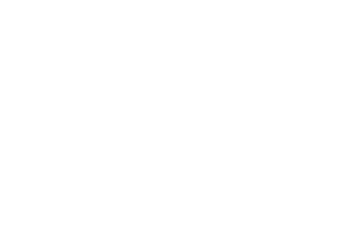

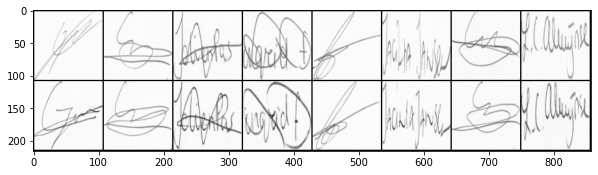

[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [ ]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## 1.4. Создадим нейросетевую модель


Поскольку веса должны быть одинаковыми для обеих сетей, мы используем одну и ту же модель и последовательно загружаем в нее два изображения. После этого мы вычисляем значение потерь, используя оба изображения, а затем выполняем обратное распространение. Такой подход экономит память, а также вычислительно эффективен.

In [ ]:
# create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

## 1.5. Зададим Contrastive loss
Для этой задачи мы будем использовать Contrastive Loss, который изучает вложения (embeddings), в которых две похожие точки имеют малое евклидово расстояние, а две разнородные точки имеют большое евклидово расстояние. В Pytorch реализация Contrastive Loss будет следующей:

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

## 1.6. Определим функцию для обучения

In [ ]:
# train the model
def train(num_epochs=20):
    loss = []
    counter = []
    iteration_number = 0

    for epoch in range(1, num_epochs):
        for i, data in enumerate(train_dataloader, 0):
            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

        print("Epoch {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    show_plot(counter, loss)
    return net

In [ ]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)

In [ ]:
# set the device to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train(30)
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

## 1.7. Тестирование модели

Теперь давайте протестируем нашу систему проверки подписи на тестовом наборе данных:
- Загрузим тестовый набор данных, используя класс DataLoader из Pytorch
- Передадим пары изображений и метки
- Найдем евклидово расстояние между изображениями
- На основе евклидова расстояния выполним вывод

In [ ]:
net.load_state_dict(torch.load('Signature/model.pt'))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


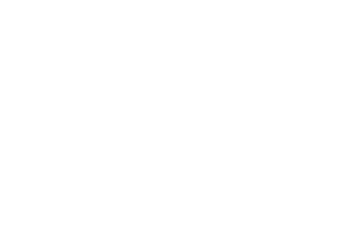

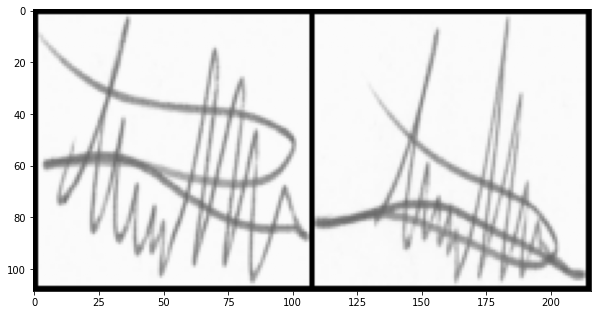

Predicted Eucledian Distance:- 1.4142135569272796e-06
Actual Label:- Original Pair Of Signature


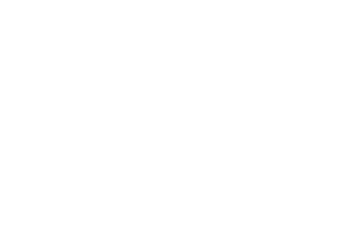

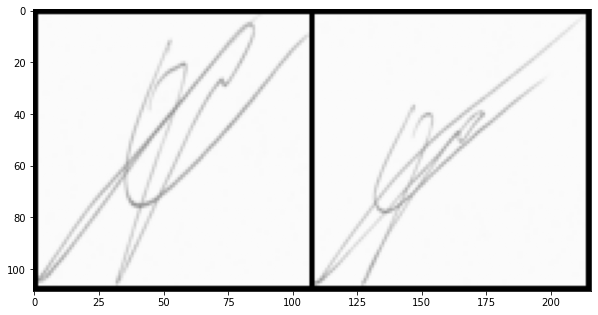

Predicted Eucledian Distance:- 0.8412206768989563
Actual Label:- Original Pair Of Signature


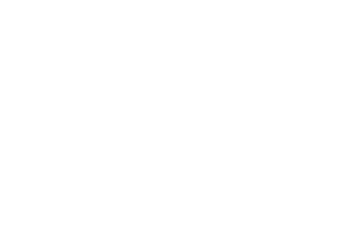

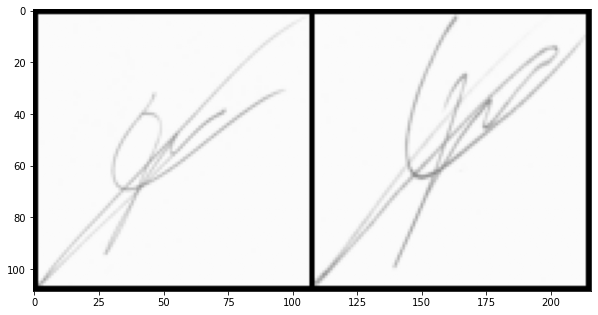

Predicted Eucledian Distance:- 1.4142135569272796e-06
Actual Label:- Original Pair Of Signature


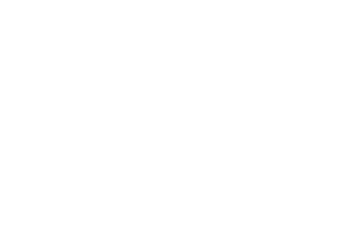

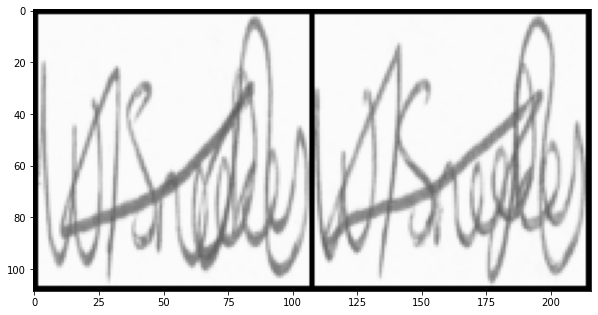

Predicted Eucledian Distance:- 1.4142135569272796e-06
Actual Label:- Original Pair Of Signature


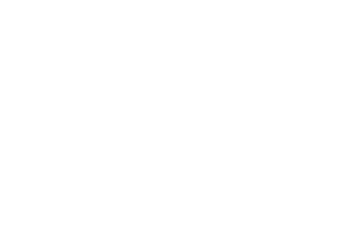

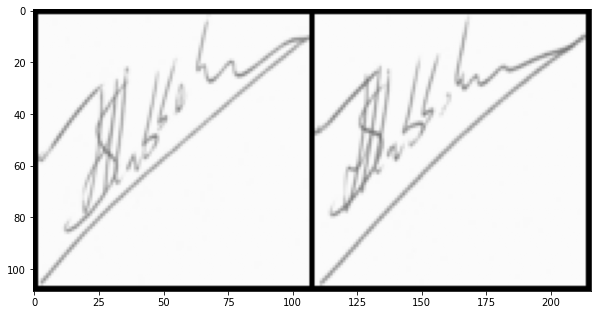

Predicted Eucledian Distance:- 1.4142135569272796e-06
Actual Label:- Original Pair Of Signature


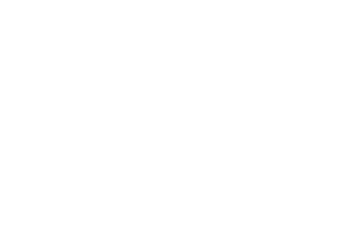

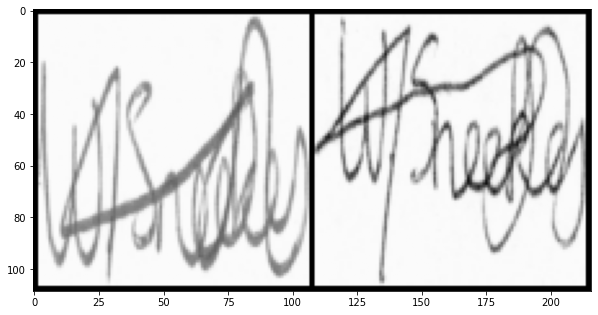

Predicted Eucledian Distance:- 0.038607072085142136
Actual Label:- Forged Pair Of Signature


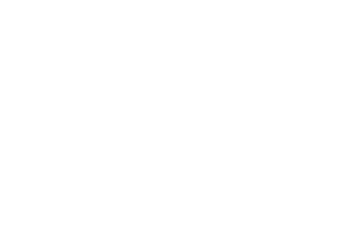

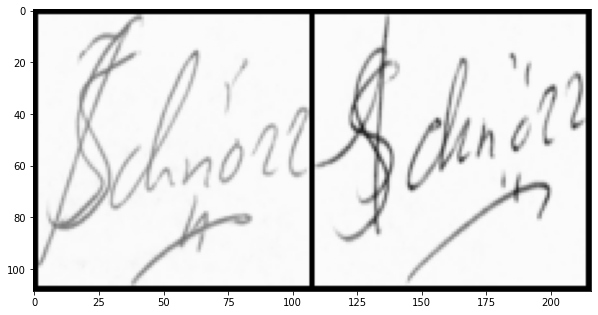

Predicted Eucledian Distance:- 1.4142135569272796e-06
Actual Label:- Forged Pair Of Signature


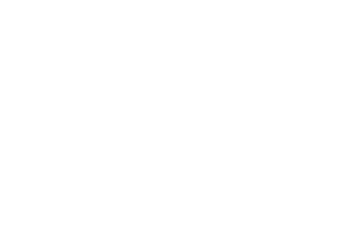

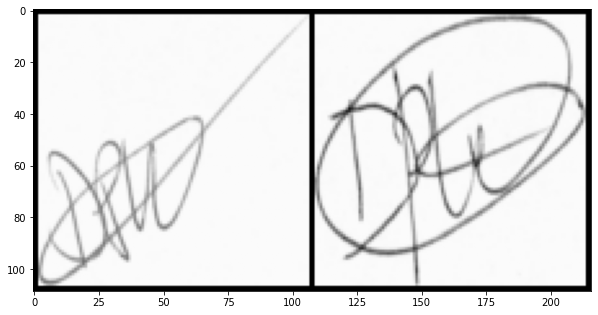

Predicted Eucledian Distance:- 1.4142135569272796e-06
Actual Label:- Forged Pair Of Signature


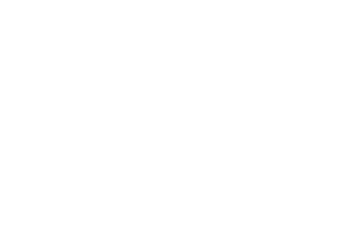

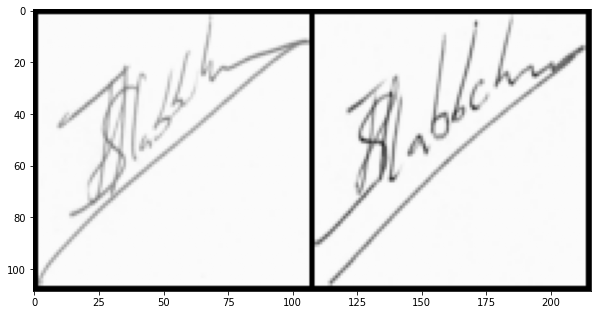

Predicted Eucledian Distance:- 0.8412206768989563
Actual Label:- Forged Pair Of Signature


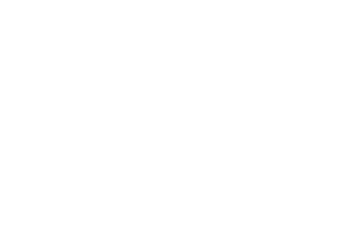

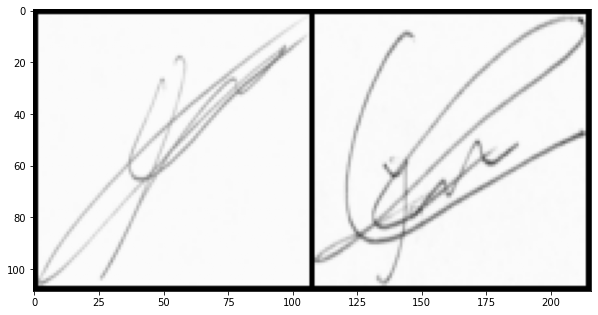

Predicted Eucledian Distance:- 0.8412206768989563
Actual Label:- Forged Pair Of Signature


In [ ]:
count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = net(x0.to(device), x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)

    if label == torch.FloatTensor([[0]]):
        label = "Original Pair Of Signature"
    else:
        label = "Forged Pair Of Signature"

    imshow(torchvision.utils.make_grid(concat))
    print("Predicted Eucledian Distance:-", eucledian_distance.item())
    print("Actual Label:-", label)
    count = count + 1
    if count == 10:
        break

# 2. Triplet loss для Seamese network и реализация на основе TF/Keras
## 2.1. Область применения
> Нужно разработать систему для идентификации сотрудников. Что будет, если мы будем решать задачу распознавания лиц (например) при помощи классификации?


**Подход через классификацию**
* Задача классификации: обучаем нейросеть присваивать вероятность принадлежности объекта к одному из классов
* К сожалению, количество классов заранее определено. В ситуации с распознаванием лиц нам придется добавлять новые классы.

**Проблемы**
* Нам нужно обучить классификатор с *очень* крупным последним слоем: например, $1024 \times n$, где $n$ (в рамках компании среднего размера) может быть $2000-3000$ тысячи
* Увольнение сотрудника решается довольно "легко" - удаляем часть матрицы. А добавление? Дообучить модель, не *изменяя* веса всех остальных классов, как правило, нельзя. Поэтому приходится обучать заново довольно крупный выходной слой, если не всю модель.
* При этом у вас может не быть большого количества фото новых сотрудников: скорее, 1-2 фото.
* Обучить модель различать двух новых, возможно, похожих людей в таких условиях непросто: выборка по новым классам слишком мала.
* "Дообучить" модель *отдельно* распознавать новых сотрдуников невозможно из-за проблемы *катастрофического забывания*
  
__Идея triplet loss__   

<figure>
<img src="https://omoindrot.github.io/assets/triplet_loss/triplet_loss.png" width="1000">
</figure> 

[Статья FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832) - в ней вводится triplet loss.

$L(A, P, N) = max(0, ||f(A) - f(P)||^2 - ||f(A) - f(N)||^2 + \alpha)  $

__Semi-hard negative mining__   

<figure>
<img src="https://omoindrot.github.io/assets/triplet_loss/triplets.png" width="500">
</figure> 

* Простые триплеты - триплеты с лоссом 0, т.к. $d(a,p) + \alpha < d(a,n)$
* Сложные триплеты (hard triplets - : триплеты, в которых отрицательный пример ближе, чем положительный: $d(a,n) < d(a,p)$
* semi-hard triplets - триплеты, в которых отрицательый пример дальше, чем положительный, но все еще в пределах margin $\alpha$: $d(a,p) < d(a,n) < d(a,p)+ \alpha$

Варианты применения триплетов
* Если сеть будет учиться на hard negatives, она может застрять в неудачном локальном минимуме.
* semi-hard negatives помогли избежать этой проблемы.
* В статье [FaceNet](https://arxiv.org/abs/1503.03832) использовали выбор случайного semi-hard примера для каждой пары "якорь-положительное значение".
  
Стратегии подбора примеров
* Оффлайн - стратегия: триплеты примеров генерируются в начале каждой эпохи
* Онлайн: для каждого батча создается $bs^3$ триплетов. Из них отбираются релевантные наборы $(2p, 1n)$. Дальше есть две стратегии:
  * batch all: усредняем лосс от всех (и hard, и semi-hard) примеров. При этом нужно игнорировать easy triplets: те, у которых лосс равен нулю
  * batch hard: для каждого из якорей в батче находим hardest positive и hardest negative.

__Пример из открытого урока по компьютерному зрению Otus:__
https://colab.research.google.com/drive/12CumvkPROfbVrx69iGtAD2b1C8jmYy4n?usp=sharing

# 3. Few-shot prototypical network
## 3.1. Подготовим библиотеки

In [ ]:
!pip install easyfsl

     |████████████████████████████████| 49 kB 2.3 MB/s 


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.data_tools import TaskSampler
from easyfsl.utils import plot_images, sliding_average

## 3.2. Подготовим датасет

In [ ]:
image_size = 28

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=False, # загружено ранее
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=False, # загружено ранее
)

## 3.3. Повторим идею Few-shot learning и Prototypical Network

Давайте разберемся, что такое "классификация с несколькими примерами" (few-shot classification). Проще говоря, в задаче few-shot classification у вас есть размеченный "поддерживающий набор" (support set) и "набор запросов" (query set). Для каждого изображения из query set мы хотим предсказать метку из меток, присутствующих в support set. Модель few-shot classification должна использовать информацию из support set для классификации query изображений. Мы говорим *few-shot*, когда support set содержит всего
несколько изображений для каждой метки (обычно менее 10). На рисунке ниже показана задача классификации 3-way 2-shots. «3-way» означает «3 разных класса», а «2-shots» означает «2 примера на класс».
Мы ожидаем, что модель, которая никогда не видела ни одного сенбернара, мопса или лабрадора во время обучения, успешно
предскажет метки запроса. Support set — это единственная информация, которой обладает модель относительно того, кто такой сенбернар, мопс и лабрадор.

![few-shot classification task](https://images.ctfassets.net/be04ylp8y0qc/bZhboqYXfYeW4I88xmMNv/7c5efdc368206feaad045c674b1ced95/1_AteD0yXLkQ1BbjQTB3Ytwg.png?fm=webp)


Большинство методов few-shot классификации основаны на метриках (metric-based). Они работают в два этапа: 1) используются CNN для проецирования обоих support и query изображений в пространство признаков, и 2) затем классифицируются query изображения через их сравнение с опорными изображениями.
Если в пространстве признаков изображение ближе к мопсам, чем к лабрадорам и сенбернарам, мы делаем предположение, что это мопс.

Возникает две проблемы:

1. Найти хорошее пространство признаков. Для этого и нужны сверточные сети. CNN — это, по сути, функция, которая принимает изображение в качестве входных данных и выводит представление (или *embedding*) этого изображения в заданном пространстве признаков. Задача здесь состоит в том, чтобы иметь CNN, которая будет проецировать изображения одного класса в представления, близкие друг к другу, даже если эта сеть не была обучена на объектах этого класса.
2. Найти хороший способ сравнить представления в пространстве признаков. Для этого предназначены Prototype Networks.


![Prototypical classification](https://images.ctfassets.net/be04ylp8y0qc/45M9UcUp6KnzwDaBHeGZb7/bb2dcda5942ee7320600125ac2310af6/0_M0GSRZri859fGo48.png?fm=webp)

Из опорных наборов Prototypical Networks вычисляют прототипы для каждого класса, каждый из которых является средним значением всех представлений опорных изображений из этого класса. Затем каждому запросу просто присваивается метка ближайшего прототипа в пространстве признаков (близость оценивается, например, через евклидово расстояние).


Перейдем к коду.
В приведенном ниже коде мы просто определяем Prototypical Networks как модуль torch с методом `forward()`.
Можно заметить 2 вещи.

1. Мы инициируем `PrototypeNetworks` с *backbone*. Это экстрактор признаков, о котором мы говорили.
Здесь мы используем в качестве основы ResNet18, предварительно обученный на ImageNet, с отрезанными слоями и замененными на «Flatten» слой. Выходом backbone для входного изображения будет 512-мерный вектор признаков.
2. Метод forward принимает не один входной тензор, а три: чтобы предсказать метки изображений запроса, нам также нужны опорные изображения и метки входных данных.

## 3.4. Создадим модель

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Теперь у нас есть модель! Обратите внимание, что мы использовали предварительно обученный экстрактор признаков, поэтому наша модель уже должна работать.

Создадим загрузчик данных, который будет передавать нашей модели few-shot classification задачи. Но обычный загрузчик данных PyTorch будет передавать пакеты изображений, независимо от их метки или того, являются ли они "опорными" (support) или "запросом" (query). В нашем случае нам нужны две особенности реализации.

Нам нужны изображения, равномерно распределенные между заданным количеством классов.
Нам нужно их разделить на наборы support и query.

Реализован собственный сэмплер: он сначала выбирает n_way классов из набора данных, затем он выбирает n_shot + n_query изображений для каждого класса (всего n_way * (n_shot + n_query) изображений в каждом пакете). Во-вторых, реализована собственная функция сопоставления (collate function), которая заменяет встроенную в PyTorch функцию collate_fn. Полученный test_loader возвращает следующие 5 элементов:
- support images
- support labels between 0 and n_way
- query images
- query labels between 0 and n_way
- a mapping of each label in range(n_way) to its true class id in the dataset (it's not used by the model but it's very useful for us to know what the true class is)

## 3.5. Предварительно протестируем модель


In [ ]:
N_WAY = 5 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "labels" field. Check the code if you have any doubt!
test_set.labels = [instance[1] for instance in test_set._flat_character_images]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


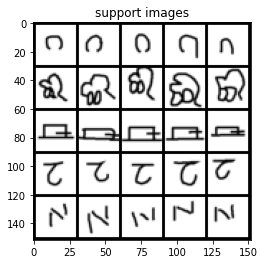

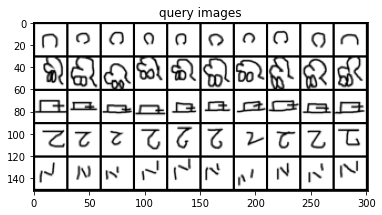

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

Как для support set, так и для query set мы имеем одну строку для каждого класса.

Как наша модель справляется с этой задачей?

In [ ]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
Malayalam/character39 / Malayalam/character39
Malayalam/character39 / Malayalam/character39
Malayalam/character39 / Malayalam/character39
Malayalam/character39 / Malayalam/character39
Malayalam/character39 / Malayalam/character39
Malayalam/character39 / Malayalam/character39
Malayalam/character39 / Malayalam/character39
Malayalam/character39 / Malayalam/character39
Malayalam/character39 / Malayalam/character39
Malayalam/character39 / Malayalam/character39
Oriya/character04 / Oriya/character04
Oriya/character04 / Oriya/character04
Oriya/character04 / Oriya/character04
Oriya/character04 / Oriya/character04
Oriya/character04 / Oriya/character04
Oriya/character04 / Oriya/character04
Oriya/character04 / Oriya/character04
Oriya/character04 / Oriya/character04
Oriya/character04 / Oriya/character04
Oriya/character04 / Oriya/character04
Keble/character23 / Keble/character23
Keble/character23 / Keble/character23
Keble/character23 / Keble/character23
Keble/character23 / K

Выглядит неплохо: имейте в виду, что модель обучалась на очень разных изображениях и видела только 5 примеров для каждого класса!

Теперь, когда у нас есть первое представление, давайте более точно посмотрим, насколько хороша наша модель.

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [02:00<00:00,  1.21s/it]

Model tested on 100 tasks. Accuracy: 85.68%


С абсолютно нулевым обучением на изображениях базы Omniglot и всего пятью примерами на класс мы достигаем точности почти 86%!

Теперь, зная, как заставить работать Prototypical Networks, мы можем модифицировать подход (изменяя backbone, используя расстояния, отличные от евклидовых...) или изменяя проблему (больше классов в каждой задаче, меньше или больше примеров в опорном наборе, возможен даже только один пример, но следует иметь в виду, что в этом случае прототипные сети являются просто стандартным классификатором по ближайшему соседу).

## 3.6. Training a meta-learning algorithm

Давайте применим изображения из Omniglot в качестве обучающего набора. Сначала подготовим загрузчик данных для 40 000 задач few-shot classification, на которых мы будем обучать нашу модель. Алфавиты, используемые в обучающем наборе, полностью отделены от используемых в тестовом наборе. Это гарантирует, что во время тестирования модель должна будет классифицировать символы, которые не использовались во время обучения.

Обратите внимание, что здесь не используется валидационная выборка для краткости, но имейте в виду, что это не очень хорошая практика.

In [ ]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set.labels = [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Оставим ту же модель. Таким образом, наши веса будут предварительно обучены на ImageNet. Если вы хотите начать обучение с нуля, возможно установить pretrained=False в определении ResNet.

Здесь мы определяем нашу функцию потерь и наш оптимизатор (кросс-энтропия и Adam, довольно стандартно) и функцию fit. Эта функция принимает задачу классификации в качестве входных данных (опорный набор и набор запросов). Она предсказывает метки набора запросов на основе информации из опорного набора; затем она сравнивает предсказанные метки с истинными метками запроса, и это дает нам значение потерь. Затем это значение функции потерь используется для обновления параметров модели. Это цикл метаобучения.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

Чтобы обучить модель, мы просто перебираем большое количество случайно сгенерированных задач few-shot classification и позволяем функции fit обновлять нашу модель после каждой задачи. Это называется эпизодическим обучением (episodic training).

In [ ]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 40000/40000 [2:09:37<00:00,  5.14it/s, loss=0.312]


In [ ]:
torch.save(model.state_dict(), "resnet18_with_pretraining.pt")
print("Model Saved Successfully")

Model Saved Successfully


In [ ]:
model.load_state_dict(torch.load('resnet18_with_pretraining.pt'))

<All keys matched successfully>

## 3.7. Оценим точность модели

In [ ]:
evaluate(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [01:20<00:00,  1.24it/s]

Model tested on 100 tasks. Accuracy: 92.44%


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


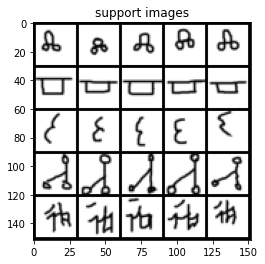

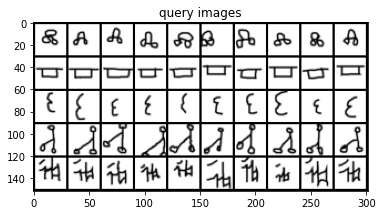

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [ ]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
Glagolitic/character15 / Glagolitic/character15
Glagolitic/character15 / Glagolitic/character15
Glagolitic/character15 / Glagolitic/character15
Glagolitic/character15 / Glagolitic/character15
Glagolitic/character15 / Glagolitic/character15
Glagolitic/character15 / Glagolitic/character15
Glagolitic/character15 / Glagolitic/character15
Glagolitic/character15 / Glagolitic/character15
Glagolitic/character15 / Glagolitic/character15
Glagolitic/character15 / Glagolitic/character15
Keble/character21 / Keble/character21
Keble/character21 / Keble/character21
Keble/character21 / Keble/character21
Keble/character21 / Keble/character21
Keble/character21 / Keble/character21
Keble/character21 / Keble/character21
Keble/character21 / Keble/character21
Keble/character21 / Keble/character21
Keble/character21 / Keble/character21
Keble/character21 / Keble/character21
Avesta/character22 / Avesta/character22
Avesta/character22 / Avesta/character22
Avesta/character22 / Avesta/charact

Неудивительно, что модель работает лучше после обучения на изображениях Omniglot, чем с параметрами на основе ImageNet. Однако мы должны иметь в виду, что классы, на которых мы только что оценивали нашу модель, все еще не присутствовали во время обучения, поэтому полученная точность кажется достойным результатом.

# 4. Image Anomaly detection на основе автоэнкодера с robust subspace recovery layer
## 4.1. Теоретическое введение

![Anomaly detection](https://www.pyimagesearch.com/wp-content/uploads/2020/03/autoencoder_anomaly_detection_example.jpg)

![Anomaly detection](https://miro.medium.com/max/1916/1*1pjIONX0hIIz4pO9P6-onA.png)


Обнаружение аномалий (или обнаружение выбросов) — одна из многих сложных задач, стоящих перед специалистами по обработке и анализу данных. Независимо от того, являются ли данные хорошо структурированными (например, пользовательские события) или неструктурированными (например, текст или изображения), существует множество методов, позволяющих решить эту проблему, и сложно выбрать какой-то один. Иногда даже сложно правильно определить, что такое аномалия. Некоторые из наиболее популярных методов обнаружения аномалий:

- статистические методы, такие как правило трех сигм и регрессионные модели
- классические методы машинного обучения - такие как one-class SVM, Isolation Forests или методы на основе кластеризации (например, kNN)
- методы глубокого обучения, такие как автоэнкодеры и модели глубокого прогнозирования (например, LSTM для временных рядов)


### Общая идея Robust Space Recovery Layer
Автоэнкодеры использовались для обнаружения аномалий намного раньше появления RSR. Чтобы использовать автоэнкодер для обнаружения аномалий, как «нормальные» примеры (inliners) рассматриваются те, которые имеют низкую ошибку реконструкции, а другие, которые имеют высокую ошибку реконструкции, рассматриваются как выбросы (outliers). Хотя идея довольно проста для понимания и реализации, проблема заключается в том, что для правильной работы автоэнкодера при таком подходе (т.е. для обнаружения выбросов) обучающие данные должны быть чистыми (или иметь очень малую долю выбросов). В реальном мире крайне маловероятно, что входные данные не будут иметь каких-либо аномалий, и даже если специалисты по данным смогут выполнить разметку и отфильтровать данные (при условии, что они знают, что такое аномалия в данном наборе данных), это не получится масштабировать.

В статье *Robust Subspace Recovery Layer* делается попытка решить эту проблему путем включения слоя RSR в автоэнкодеры. Установлено, что этот метод не конкурирует с полуконтролируемыми или контролируемыми методами обнаружения аномалий (при обучении с частичным привлечением учителя - semi-supervised или при обучении с учителем - supervised), но показывает свою силу в неконтролируемой (unsupervised) настройке (при обучении без учителя).



### Что такое слой RSR?
Слой RSR — это просто дополнительный слой в нейронной сети со специфическими свойствами. Он отображает одно представление (embedding, полученное из кодировщика) в другое **низкоразмерное представление, устойчивое к выбросам**.

Предположим, что *D* — это размер embedding'а из кодировщика. Предполагается, что «нормальные» данные лежат внутри *d*-мерного многообразия («подпространства») исходного embedding'а, что означает, что *d < D*.



### Как реализовать слой RSR в PyTorch?
Поскольку слой RSR — это просто линейное отображение, необходимо всего несколько вещей:
1. Размерность *D* с выхода энкодера.
2. Размерность *d*, которое является свойством слоя RSR (и, вероятно, требует поиска гиперпараметров, чтобы установить его правильно).
3. Надлежащая инициализация весов линейного отображения.

Реализация самого слоя проста.

In [ ]:
!pip install pytorch-lightning scikit-learn plotly

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

## 4.2. Реализуем компоненты RSR слоя

In [ ]:
class RSRLayer(nn.Module):
    def __init__(self, d:int, D: int):
        super().__init__()
        self.d = d
        self.D = D
        self.A = nn.Parameter(torch.nn.init.orthogonal_(torch.empty(d, D)))

    def forward(self, z):
        # z is the output from the encoder
        z_hat = self.A @ z.view(z.size(0), self.D, 1)
        return z_hat.squeeze(2)

Следующим шагом для получения RSR Autoencoder в PyTorch является реализация RSR Loss в соответствии с уравнением (4) статьи:



![Anomaly detection](https://zablo.net/resources/rsr-layer/rsrloss.gif)


Первая составляющая обеспечивает robustness проекции RSR, а вторая обеспечивает ортогональность проекции. Подробности приводятся в оригинальной статье.

Реализация этой функции потерь выглядит так:

In [ ]:
class RSRLoss(nn.Module):
    def __init__(self, lambda1, lambda2, d, D):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.d = d
        self.D = D
        self.register_buffer(
            "Id", torch.eye(d)
        )

    def forward(self, z, A):
        z_hat = A @ z.view(z.size(0), self.D, 1)
        AtAz = (A.T @ z_hat).squeeze(2)
        term1 = torch.sum(
            torch.norm(z - AtAz, p=2)
        )

        term2 = torch.norm(
            A @ A.T - self.Id, p=2
        ) ** 2

        return self.lambda1 * term1 + self.lambda2 * term2

Наконец, стандартные L1/L2 функции потерь реконструкции заменяются потерями на основе l2,p-нормы:


![Anomaly detection](https://zablo.net/resources/rsr-layer/l2ploss.gif)

In [ ]:
class L2p_Loss(nn.Module):
    def __init__(self, p=1.0):
        super().__init__()
        self.p = p
  
    def forward(self, y_hat, y):
        return torch.sum(
            torch.pow(
                torch.norm(y - y_hat, p=2), self.p
            )
        )

## 4.3. Реализуем архитектуру RSR autoencoder

In [ ]:
class RSRAutoEncoder(nn.Module):
    def __init__(self, input_dim, d, D):
        super().__init__()
        # Put your encoder network here, remember about the output D-dimension
        self.encoder = nn.Sequential(
          nn.Linear(input_dim, input_dim // 2),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 2, input_dim // 4),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 4, D)
        )

        self.rsr = RSRLayer(d, D)

        # Put your decoder network here, rembember about the input d-dimension
        self.decoder = nn.Sequential(
          nn.Linear(d, D),
          nn.LeakyReLU(),
          nn.Linear(D, input_dim // 2),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 2, input_dim)
        )
    
    def forward(self, x):
        enc = self.encoder(x) # obtain the embedding from the encoder
        latent = self.rsr(enc) # RSR manifold
        dec = self.decoder(latent) # obtain the representation in the input space
        return enc, dec, latent, self.rsr.A

## 4.4. Подготовим датасет MNIST и его искаженную версию

In [ ]:
import pytorch_lightning as pl

In [ ]:
pl.seed_everything(42)

Global seed set to 42


42

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
# https://github.com/pytorch/vision/issues/1938#issuecomment-594623431
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

mnist = MNIST(".", download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
class RSRDs(torch.utils.data.Dataset):
    def __init__(self, target_class, other_classes, n_examples_per_other):
        super().__init__()
        self.mnist = MNIST(".", download=True, transform=ToTensor())
        self.target_indices = (self.mnist.targets == target_class).nonzero().flatten()
        
        other = []
        for other_class in other_classes:
            other.extend(
                (self.mnist.targets == other_class).nonzero().flatten()[:n_examples_per_other]
            )
        self.other_indices = torch.tensor(other)
        self.all_indices = torch.cat([self.other_indices, self.target_indices])
        print(f"Targets: {self.target_indices.size(0)}")
        print(f"Others : {self.other_indices.size(0)}")
    
    def __getitem__(self, idx):
        actual_idx = self.all_indices[idx].item()
        return self.mnist[actual_idx]
    
    def __len__(self):
        return self.all_indices.size(0)

In [ ]:
ds = RSRDs(target_class=4, other_classes=(0, 1, 2, 8), n_examples_per_other=100)

Targets: 5842
Others : 400


In [ ]:
ds[0][0].shape, ds[0][1]

(torch.Size([1, 28, 28]), 0)

## 4.5. Соберем RSRAutoencoder

Следующий модуль объединяет все части вместе:
1. Автоэнкодер RSR со слоем RSR внутри,
2. L2p функция потерь реконструкции,
3. RSR функция потерь.

In [ ]:
class RSRAE(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        # self.hparams = hparams
        for key in hparams.keys():
         self.hparams[key]=hparams[key]

        self.ae = RSRAutoEncoder(
            self.hparams.input_dim, 
            self.hparams.d, 
            self.hparams.D)
        self.reconstruction_loss = L2p_Loss(p=1.0)
        self.rsr_loss = RSRLoss(self.hparams.lambda1, self.hparams.lambda2, self.hparams.d, self.hparams.D)
  
    def forward(self, x):
        return self.ae(x)
  
    def training_step(self, batch, batch_idx):
        X, _ = batch
        x = X.view(X.size(0), -1)
        enc, dec, latent, A = self.ae(x)

        rec_loss = self.reconstruction_loss(torch.sigmoid(dec), x)
        rsr_loss = self.rsr_loss(enc, A)
        loss = rec_loss + rsr_loss
        
        # log some usefull stuff
        self.log("reconstruction_loss", rec_loss.item(), on_step=True, on_epoch=False, prog_bar=True)
        self.log("rsr_loss", rsr_loss.item(), on_step=True, on_epoch=False, prog_bar=True)
        return {"loss": loss}

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        # Fast.AI's best practices :)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=self.hparams.lr, 
                                                        epochs=self.hparams.epochs, 
                                                        steps_per_epoch=self.hparams.steps_per_epoch)
        return [opt], [{
            "scheduler": scheduler,
            "interval": "step"
        }]

In [ ]:
from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size=64, shuffle=True, drop_last=True)

In [ ]:
hparams = dict(
    d=16,
    D=128,
    input_dim=28*28,
    # Peak learning rate
    lr=0.01,
    # Configuration for the OneCycleLR scheduler
    epochs=150,
    steps_per_epoch=len(dl),
    # lambda coefficients from RSR Loss
    lambda1=1.0,
    lambda2=1.0,
)
model = RSRAE(hparams)
model

RSRAE(
  (ae): RSRAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=392, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=392, out_features=196, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=196, out_features=128, bias=True)
    )
    (rsr): RSRLayer()
    (decoder): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=392, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=392, out_features=784, bias=True)
    )
  )
  (reconstruction_loss): L2p_Loss()
  (rsr_loss): RSRLoss()
)

## 4.6. Обучим модель

In [ ]:
trainer = pl.Trainer(max_epochs=model.hparams.epochs, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dl)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type           | Params
-------------------------------------------------------
0 | ae                  | RSRAutoEncoder | 772 K 
1 | reconstruction_loss | L2p_Loss       | 0     
2 | rsr_loss            | RSRLoss        | 0     
-------------------------------------------------------
772 K     Trainable params
0         Non-trainable params
772 K     Total params
3.091     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

## 4.7. Оценим модель

Во-первых, проверим общую реконструкцию автоэнкодера.

In [ ]:
model.freeze()
from torchvision.transforms import functional as tvf
from torchvision.utils import make_grid
def reconstruct(x, model):
    enc, x_hat, latent, A = model(x.view(1, -1))
    # x_img = tvf.to_pil_image(
    #     x_hat.squeeze(0).view(1, 28, 28)
    # )
    x_hat = torch.sigmoid(x_hat)
    return tvf.to_pil_image(
      make_grid([x_hat.squeeze(0).view(1, 28, 28), x])
    )

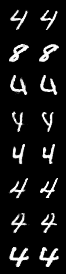

In [ ]:
tvf.to_pil_image(
    make_grid([tvf.to_tensor(reconstruct(ds[i][0], model)) for i in torch.randint(0, len(ds), (8, ))], nrow=1)
)

Большинство изображений кажутся нормальными, учитывая, насколько проста модель. Теперь давайте посмотрим на embedding пространство RSR, спроецированное в 3D с помощью PCA.

In [ ]:
import pandas as pd
rsr_embeddings = []
classes = []
errors = []
for batch in iter(DataLoader(ds, batch_size=64, shuffle=False)):
    X, cl = batch
    x = X.view(X.size(0), -1)
    enc, x_hat, latent, A = model(x)
    rsr_embeddings.append(latent)
    classes.extend(cl.numpy())
    for i in range(X.size(0)):
        rec_error = L2p_Loss()(torch.sigmoid(x_hat[i]).unsqueeze(0), x[i].unsqueeze(0))
        errors.append(float(rec_error.numpy()))
        
all_embs = torch.vstack(rsr_embeddings)
df = pd.DataFrame(all_embs.numpy(), columns=["x", "y", "z"] + [f"dim_{i}" for i in range(hparams["d"] - 3)])
df.loc[:, "class"] = classes
df.loc[:, "errors"] = errors

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
rsr_3d = pd.DataFrame(pca.fit_transform(all_embs), columns=["x", "y", "z"])
rsr_3d.loc[:, "class"] = classes

In [ ]:
!pip install pyyaml==5.4.1

In [ ]:
import plotly.express as px
import plotly
df = df
fig = px.scatter_3d(df, x='x', y='y', z='z',
               symbol="class", color="class", opacity=0.95)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Действительно, большая часть примеров из класса 4 (основной класс — inliners) находится в центре пространства, а другие классы расположены дальше от центра.


## 4.8. Применение unsupervised anomaly detection на основе RSR Autoencoder

In [ ]:
df.errors.describe()

count    6242.000000
mean        1.571933
std         0.299981
min         0.595101
25%         1.372140
50%         1.535987
75%         1.729964
max         3.394237
Name: errors, dtype: float64

class
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
8    AxesSubplot(0.125,0.125;0.775x0.755)
Name: errors, dtype: object

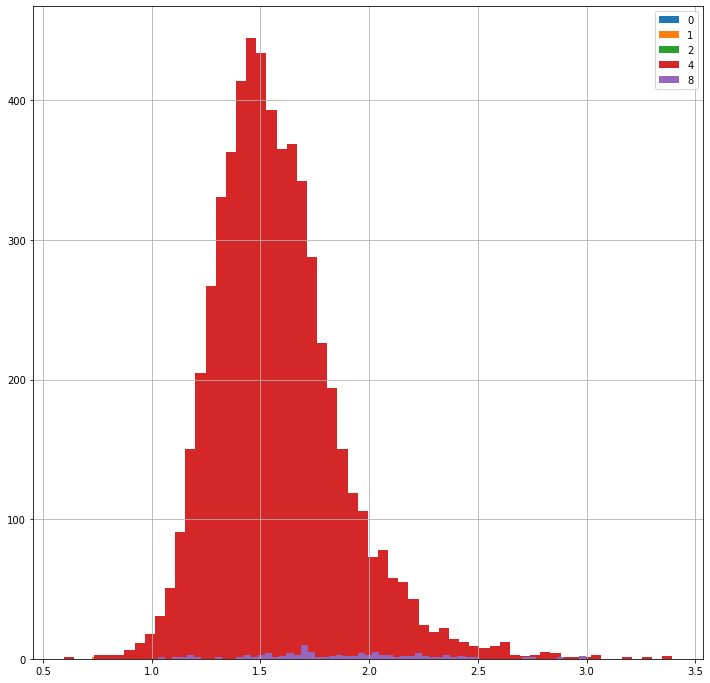

In [ ]:
df.groupby("class").errors.hist(legend=True, bins=60, figsize=(12, 12))

Значения reconstruction loss сосредоточены вокруг 1,5 с распространением хвоста до 3,46. Каким классам принадлежат примеры с наибольшими ошибками?

In [ ]:
lowest_mistakes = df.sort_values(by="errors", ascending=True).head(60).loc[:, ["errors", "class"]]
highest_mistakes = df.sort_values(by="errors", ascending=False).head(60).loc[:, ["errors", "class"]]
highest_mistakes.head(10)

,errors,class
6017,3.394237,4
5917,3.391846,4
1619,3.268096,4
5528,3.170985,4
2201,3.065314,4
5936,3.058208,4
3515,3.024236,4
335,2.996810,8
371,2.983447,8
634,2.978573,4


Сначала это кажется очень странным, так как ожидается, что иметь самые большие ошибки будут классы, отличные от вышеупомянутого класса 4. Но давайте внимательно посмотрим на фактические результаты:

Images with the highest reconstruction loss


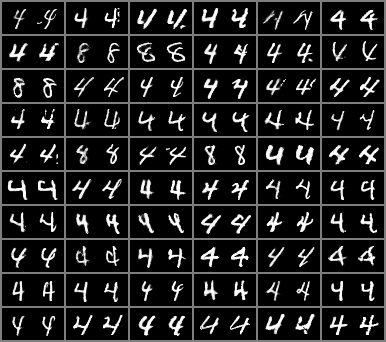

In [ ]:
print("Images with the highest reconstruction loss")
tvf.to_pil_image(
    make_grid([tvf.to_tensor(reconstruct(ds[i][0], model)) for i in highest_mistakes.index], nrow=6,
             pad_value=0.5)
)

Images with the lowest reconstruction loss


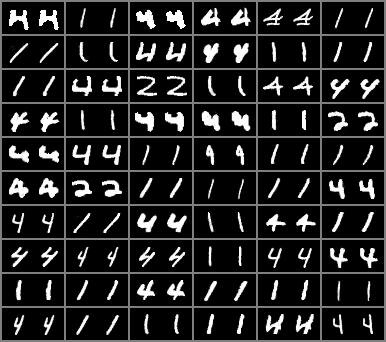

In [ ]:
print("Images with the lowest reconstruction loss")
tvf.to_pil_image(
    make_grid([tvf.to_tensor(reconstruct(ds[i][0], model)) for i in lowest_mistakes.index], nrow=6,
             pad_value=0.5)
)

Теперь стало намного понятнее - модель нашла многообразие (manifold), разделяющее изображения на "нормальные" - которые в этой настройке кажутся более гладкими с четкими кривыми - и выбросы, довольно резкие, которые содержат какие-то случайные артефакты (являющиеся аномалиями). Учитывая простоту модели и настройку, эта модель кажется хорошей отправной точкой для неконтролируемого обнаружения аномалий.

# 5. Unsupervised domain adaptation
## 5.1. Постановка задачи
<figure>
<img src="https://nbviewer.jupyter.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/img/tl_example.png" width="500">
</figure>  


Рассмотрим задачу с разными доменами, но с одинаковой задачей:
- Исходный домен: MNIST
- Целевой домен: MNIST-M, цветная и текстурированная версия MNIST.

Задачей в обоих случаях является обычная 10-ти классовая классификация цифр.



<figure>
<img src="https://nbviewer.jupyter.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/img/mnist_m.png" width="500">
</figure>  



Настройка неконтролируемого DA: мы предполагаем, что для целевого домена нет доступных меток.

Нам нужно заставить нашу CNN изучать признаки, основанные только на форме цифр, а не на распределении цветов.

Наш подход (на основе Ganin et al. 2015):

- Обучите классификатор домена изображения на основе глубоких сверточных признаков.
- Старайтесь максимизировать потери этого классификатора при обучении CNN (confusion loss).
- Одновременно минимизируйте потери классификации в исходном домене, используя те же сверточные признаки.
- Обучите классификатор цифр на данных исходного домена и классификатор домена с данными обоих доменов.



<figure>
<img src="https://nbviewer.jupyter.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/img/ganin_da.png" width="1000">
</figure> 




In [ ]:
# Setup
%matplotlib inline
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.utils.data as data
from PIL import Image

import math
import itertools

import numpy as np
import matplotlib.pyplot as plt

## 5.2. Подготовим датасет

In [ ]:
class MNISTMDataset(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

In [ ]:
import torchvision.transforms as tvtf
import torchvision as tv
image_size = 28
batch_size = 4
data_dir = "data_dir"
tf_source = tvtf.Compose([
    tvtf.Resize(image_size),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=(0.1307,), std=(0.3081,))
])
tf_target = tvtf.Compose([
    tvtf.Resize(image_size),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

ds_source = tv.datasets.MNIST(root=data_dir, train=True, transform=tf_source, download=True)
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)

In [ ]:
!ls data_dir

MNIST  mnist_m.tar.gz


In [ ]:
!tar -xf 'data_dir/mnist_m.tar.gz' -C 'data_dir/'

In [ ]:
data_dir = "data_dir"
ds_target = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_train'),
                          os.path.join(data_dir, 'mnist_m', 'mnist_m_train_labels.txt'),
                         transform=tf_target)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

Визуализируем данные

In [ ]:
def tensors_as_images(tensors, nrows=1, figsize=(8, 8), titles=[],
                      wspace=0.1, hspace=0.2, cmap=None):
    """
    Plots a sequence of pytorch tensors as images.
    :param tensors: A sequence of pytorch tensors, should have shape CxWxH
    """
    assert nrows > 0

    num_tensors = len(tensors)

    ncols = math.ceil(num_tensors / nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             gridspec_kw=dict(wspace=wspace, hspace=hspace),
                             subplot_kw=dict(yticks=[], xticks=[]))
    axes_flat = axes.reshape(-1)

    # Plot each tensor
    for i in range(num_tensors):
        ax = axes_flat[i]

        image_tensor = tensors[i]
        assert image_tensor.dim() == 3  # Make sure shape is CxWxH

        image = image_tensor.numpy()
        image = image.transpose(1, 2, 0)
        image = image.squeeze()  # remove singleton dimensions if any exist

        # Scale to range 0..1
        min, max = np.min(image), np.max(image)
        image = (image-min) / (max-min)

        ax.imshow(image, cmap=cmap)

        if len(titles) > i and titles[i] is not None:
            ax.set_title(titles[i])

    # If there are more axes than tensors, remove their frames
    for j in range(num_tensors, len(axes_flat)):
        axes_flat[j].axis('off')

    return fig, axes


def dataset_first_n(dataset, n, show_classes=False, class_labels=None,
                    random_start=True, **kw):
    """
    Plots first n images of a dataset containing tensor images.
    """

    if random_start:
        start = np.random.randint(0, len(dataset) - n)
        stop = start + n
    else:
        start = 0
        stop = n

    # [(img0, cls0), ..., # (imgN, clsN)]
    first_n = list(itertools.islice(dataset, start, stop))

    # Split (image, class) tuples
    first_n_images, first_n_classes = zip(*first_n)

    if show_classes:
        titles = first_n_classes
        if class_labels:
            titles = [class_labels[cls] for cls in first_n_classes]
    else:
        titles = []

    return tensors_as_images(first_n_images, titles=titles, **kw)

In [ ]:
!ls data_dir/'mnist_m'/mnist_m_train

Выходные данные были обрезаны до нескольких последних строк (5000).
00006801.png  00018602.png  00030403.png  00042204.png	00054005.png
00006802.png  00018603.png  00030404.png  00042205.png	00054006.png
00006803.png  00018604.png  00030405.png  00042206.png	00054007.png
00006804.png  00018605.png  00030406.png  00042207.png	00054008.png
00006805.png  00018606.png  00030407.png  00042208.png	00054009.png
00006806.png  00018607.png  00030408.png  00042209.png	00054010.png
00006807.png  00018608.png  00030409.png  00042210.png	00054011.png
00006808.png  00018609.png  00030410.png  00042211.png	00054012.png
00006809.png  00018610.png  00030411.png  00042212.png	00054013.png
00006810.png  00018611.png  00030412.png  00042213.png	00054014.png
00006811.png  00018612.png  00030413.png  00042214.png	00054015.png
00006812.png  00018613.png  00030414.png  00042215.png	00054016.png
00006813.png  00018614.png  00030415.png  00042216.png	00054017.png
00006814.png  00018615.png  00030416.png  000422

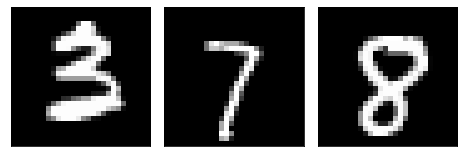

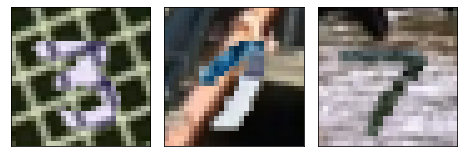

In [ ]:
dataset_first_n(ds_source, 3, cmap='gray')
dataset_first_n(ds_target, 3)

## 5.3. Построим модель

Наша модель будет состоять из трех частей, как на рисунке:

- «Глубокая» CNN для извлечения признаков изображения (2x Conv, ReLU, MaxPool)
- digit-classification head (3x FC, ReLU)
- domain classification head (2x FC, ReLU) со слоем gradient reversal layer (GRL)


<figure>
<img src="https://nbviewer.jupyter.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/img/ganin_da2.png" width="1000">
</figure> 

In [ ]:
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

In [ ]:
import torch.nn as nn

class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50), nn.Dropout2d(), nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), nn.Dropout2d(),
            nn.ReLU(True),
            nn.Linear(100, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        class_pred = self.class_classifier(features)
        domain_pred = self.domain_classifier(reverse_features)

Зачем позволять λ (grl_lambda в коде) изменяться во время обучения (например, каждую эпоху)?

- В начале обучения domain loss очень шумная, так как признаки CNN еще не очень хороши.
- Поэтому в процессе обучения λ постепенно изменяется от 0 до 1.

$$ \lambda_p = \frac{2}{1+\exp(-10\cdot p)} -1, $$
где p∈[0,1] — прогресс обучения.



In [ ]:
model = DACNN()

x0_s, y0_s = next(iter(dl_source))
x0_t, y0_t = next(iter(dl_target))

print('source domain: ', x0_s.shape, y0_s.shape)
print('target domain: ', x0_t.shape, y0_t.shape)

model(x0_s)
model(x0_t)

source domain:  torch.Size([4, 1, 28, 28]) torch.Size([4])
target domain:  torch.Size([4, 3, 28, 28]) torch.Size([4])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning:

dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).



## 5.4. Обучение модели


In [ ]:
import torch.optim as optim
lr = 1e-3
n_epochs = 1

# Setup optimizer as usual
model = DACNN()
optimizer = optim.Adam(model.parameters(), lr)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

In [ ]:
batch_size = 1024
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target))

In [ ]:
for epoch_idx in range(n_epochs):
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)

    for batch_idx in range(max_batches):
        optimizer.zero_grad()
        # Training progress and GRL lambda
        p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(dl_source_iter)
        y_s_domain = torch.zeros(batch_size, dtype=torch.long) # generate source domain labels

        class_pred, domain_pred = model(X_s.cuda(), grl_lambda)
        loss_s_label = loss_fn_class(class_pred, y_s)
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain)

        # Train on target domain
        X_t, _ = next(dl_target_iter) # ignore target domain class labels!
        y_t_domain = torch.ones(batch_size, dtype=torch.long) # generate target domain labels

        _, domain_pred = model(X_t, grl_lambda)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain)
        
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()
        
        print(f'[{batch_idx+1}/{max_batches}] '
              f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
              f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
             )
        if batch_idx == 2:
            print('This is just a demo, stopping...')
            break

    torch.save(model.state_dict(), "./checkpoints/domain_adapt.pt")
    torch.save(optimizer.state_dict(), "./checkpoints/domain_adapt_optimizer.pt")

## 5.5. Визуализация embedding'ов
Полезно визуализировать пространство сверточных признаков, изученных моделью.

Напомним, наша domain confusion loss должна сделать изображения из обоих доменов одинаковыми для классификатора.

<figure>
<img src="https://nbviewer.jupyter.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/img/ganin_da3.png" width="1000">
</figure> 

# 6. Использованные материалы
- https://towardsdatascience.com/a-friendly-introduction-to-siamese-networks-85ab17522942
- https://www.sicara.ai/blog/your-few-shot-model-15mn-pytorch
- https://zablo.net/blog/post/robust-space-recovery-rsrlayer-pytorch/



# Задание
* Применить Unsupervised domain adaptation к базам данных (можно к MNIST и MNIST-M).  
* Определить точности на целевой выборке.  
* Визуализировать пространство сверточных признаков (embeddings), например, с применением tsne.